## EDA + Logistic Regression + PCA

このカーネルは 主成分分析（PCA）、つまり次元削減手法に関するものです。

ここでは 主成分分析（PCA） について説明しています。具体的には、PCAの導入、分散比（explained variance ratio）、PCAを用いたロジスティック回帰、適切な次元数の決定、次元数ごとの分散比のプロットについて取り上げています。

このカーネルでは adult データセット を使用しています。このデータセットはPCAには非常に小さいですが、PCAの実装を示すのが主な目的です。



### 目次



このカーネルの内容は、以下のさまざまなトピックに分かれています：

- 次元の呪い

- 主成分分析（PCA）の紹介

- Pythonライブラリのインポート

- データセットのインポート

- 探索的データ分析（EDA）

- 訓練用・テスト用データの分割

- 特徴量エンジニアリング

- 特徴量のスケーリング

- 全特徴量を用いたロジスティック回帰モデル

- PCAを用いたロジスティック回帰

- 適切な次元数の選択

- 次元数に対する説明分散比のプロット

- 結論

- 参考文献


### 次元の呪い（The Curse of Dimensionality）


一般に、実世界のデータセットには、学習すべき特徴量が何千、あるいは何百万と存在することがあります。これは非常に時間のかかる作業であり、学習を極めて遅くしてしまいます。このような状況では、良い解を見つけるのが非常に困難になります。この問題はしばしば 「次元の呪い」 と呼ばれます。

次元の呪い（curse of dimensionality） とは、私たちが高次元空間（しばしば数百から数千の次元を持つ）でデータを分析・整理する際に生じる、さまざまな現象を指します。これらの現象は、低次元空間では見られないものです。次元数が増えると、空間の体積が急激に増加し、利用可能なデータがまばらになってしまいます。このスパース性（疎性）は、統計的有意性を必要とするあらゆる手法にとって問題となります。

実際の問題では、多くの場合、次元数を大幅に削減することが可能です。このプロセスは 次元削減（dimensionality reduction） と呼ばれます。これは、主成分変数の集合を取得することによって、検討する次元の数を減らすことを指します。次元削減は、学習を高速化するのに役立つだけでなく、データの可視化にも非常に有効です。

最もよく使われる次元削減手法は、以下で説明する 主成分分析（PCA：Principal Component Analysis） です。


### 主成分分析（PCA）の紹介




主成分分析（PCA：Principal Component Analysis） は、次元削減の手法であり、より多くの特徴量を持つデータを、情報（分散）をなるべく保ったまま、より小さい特徴量の集合に圧縮するために使用されます。

#### 分散を保つ（Preserve the variance）

PCAはまず、データに最も近い超平面（hyperplane）を特定し、その平面上にデータを射影（プロジェクション）します。この低次元空間への投影を行うには、まず適切な超平面を選ぶ必要があります。
この射影は、データの分散（情報の広がり）を最大限に保つように行うことが可能です。これがPCAの基本的な考え方です。

#### 主成分（Principal Components）
PCAでは、**訓練データ中の分散の累積和を最大にする軸（方向）**を見つけます。これらの軸は「主成分」と呼ばれます。
PCAは、**データが原点を中心にしている（中心化されている）**ことを前提としています。
Scikit-Learn の PCA クラスは、自動的にこの中心化（平均を0にする処理）を行ってくれます。

#### d 次元への射影（Projecting down to d Dimensions）
すべての主成分を特定したら、上位の d 個の主成分に基づいて超平面を定義し、そこへデータを射影することで、データの次元数を d に削減することができます。
この操作により、なるべく多くの分散（情報）を保持したまま、次元削減が可能になります。



Now, let's get to the implementation.

### Import Python libraries

In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Working with os module - os is a module in Python 3.
# Its main purpose is to interact with the operating system. 
# It provides functionalities to manipulate files and folders.


### Chck file size

In [44]:
print('# File sizes')
for f in os.listdir('./data'):
    print(f.ljust(30) + str(round(os.path.getsize('./data/' + f) / 1000000, 2)) + 'MB')

# File sizes
adult.csv                     4.1MB


### Import dataset

In [45]:
%%time

file = ('./data/adult.csv')
df = pd.read_csv(file, encoding='latin-1')

CPU times: total: 46.9 ms
Wall time: 33.5 ms


In [46]:
df.shape

(32561, 15)

In [47]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [49]:
df[df == '?'] = np.nan

<Axes: >

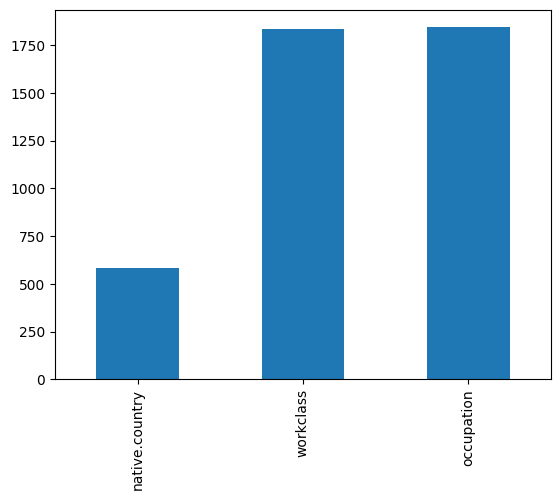

In [50]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

### 最頻値（モード）で欠損値を補完する

In [51]:
for col in missing.index:
    print(f'Column {col} has {df[col].isnull().sum()} missing values')
    df[col].fillna(df[col].mode()[0], inplace=True)

Column native.country has 583 missing values
Column workclass has 1836 missing values
Column occupation has 1843 missing values


In [52]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

### Frequency Distribution

<Axes: xlabel='income', ylabel='count'>

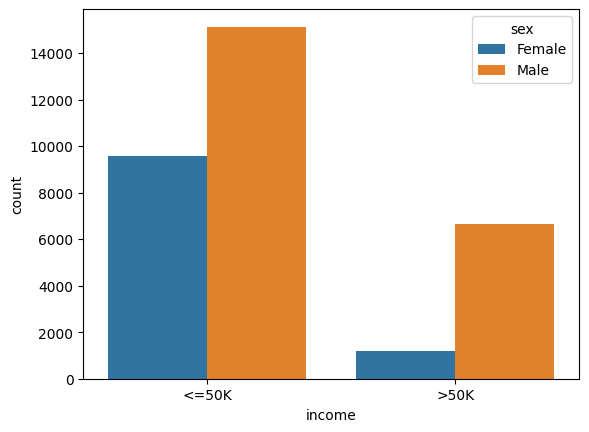

In [61]:
sns.countplot(data=df,x='income',hue='sex')

In [54]:
X = df.drop(['income'], axis=1)

y = df['income']

X.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


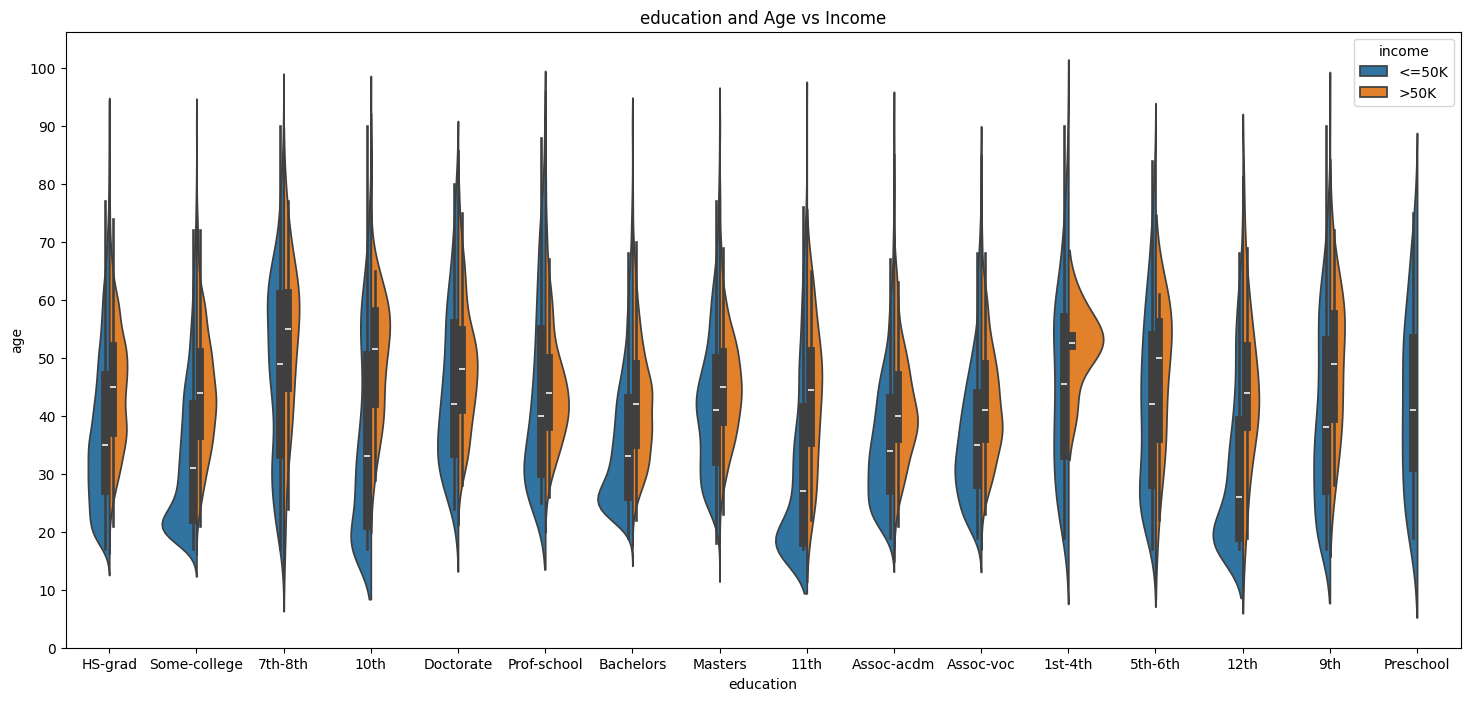

In [67]:
f,ax=plt.subplots(1,figsize=(18,8))
sns.violinplot(x="education",y="age", hue="income", data=df,split=True,ax=ax)
ax.set_title('education and Age vs Income')
ax.set_yticks(range(0,110,10))

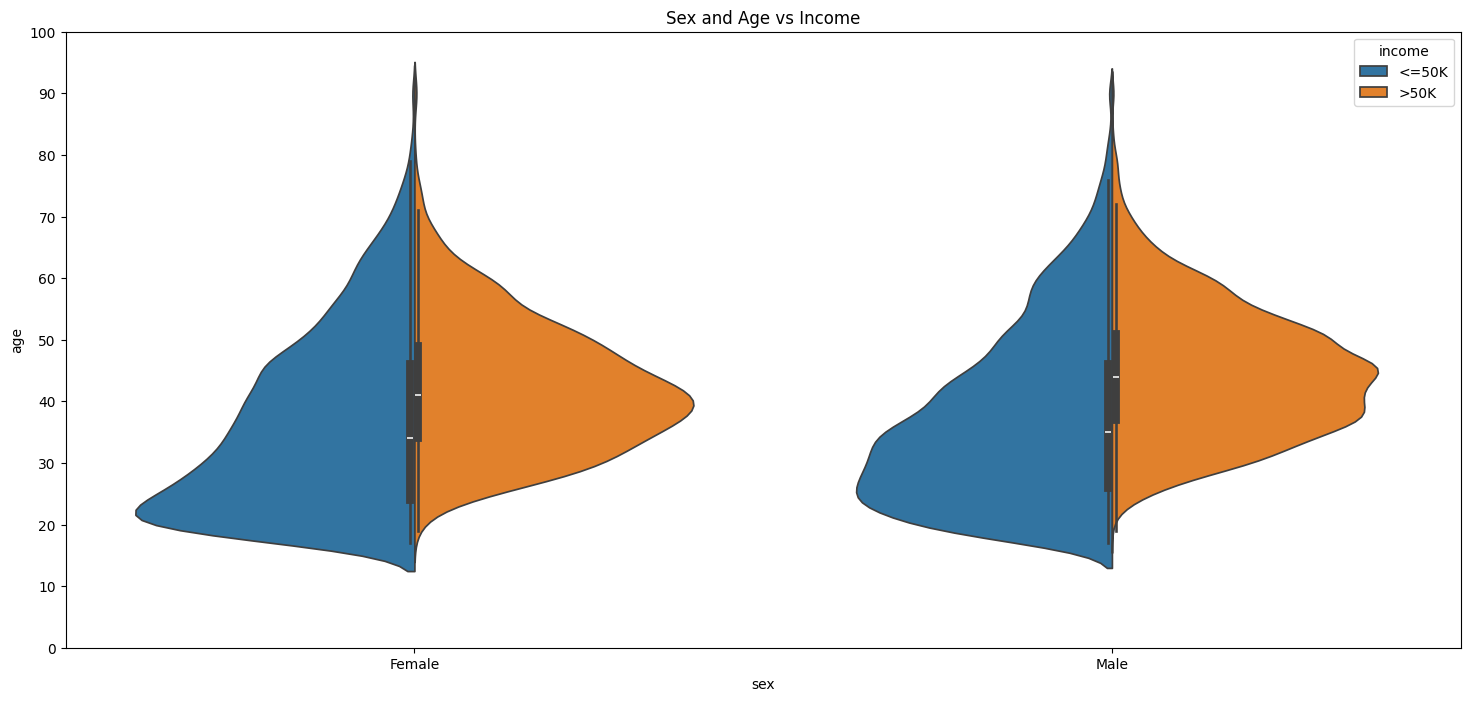

In [69]:
f,ax=plt.subplots(1,figsize=(18,8))
sns.violinplot(x="sex",y="age", hue="income", data=df,split=True,ax=ax)
ax.set_title('Sex and Age vs Income')
ax.set_yticks(range(0,110,10))
plt.show()

In [63]:
print('Oldest Passenger was of:',df['age'].max(),'Years')
print('Youngest Passenger was of:',df['age'].min(),'Years')
print('Average Age on the ship:',df['age'].mean(),'Years')

Oldest Passenger was of: 90 Years
Youngest Passenger was of: 17 Years
Average Age on the ship: 38.58164675532078 Years


In [55]:
y

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557    <=50K
32558     >50K
32559    <=50K
32560    <=50K
Name: income, Length: 32561, dtype: object

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### 特徴量エンジニアリング

#### Encode categorical variables

In [57]:
from sklearn import preprocessing

categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])

#### Feature Scaling

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [76]:
X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1.213707,1.209164,-2.026444,0.325832,-1.539116,0.137612,2.270213,0.763770,-0.400277,0.044652,-0.094952,-0.597348,1.921835,1.192279
1,-0.432902,-0.411376,0.125022,0.186093,0.905932,-0.214948,-1.816042,-0.503038,-0.174606,-0.512694,-0.400547,-0.471005,-0.429507,-0.305447
2,0.450138,0.905500,-0.366643,0.257489,0.220510,-0.674792,0.148403,-0.015661,-0.133121,-0.655505,-0.425346,1.259174,-0.862749,-1.641450
3,0.754680,-0.066401,0.740490,0.619092,1.060530,-0.819088,-1.501567,-0.341134,0.535749,-0.168538,-0.351199,0.068110,-0.516397,1.625456
4,-0.723515,0.912773,-0.201362,-0.095742,1.371102,-0.181926,-1.994020,-1.622345,0.587048,-0.648467,-1.069999,-0.362585,1.226512,0.011179


<NumpyExtensionArray>
[           'age',      'workclass',         'fnlwgt',      'education',
  'education.num', 'marital.status',     'occupation',   'relationship',
           'race',            'sex',   'capital.gain',   'capital.loss',
 'hours.per.week', 'native.country']
Length: 14, dtype: object

### Logistic Regression model with all features

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with all the features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score with all the features: 0.8218


### PCAによるロジスティック回帰（Logistic Regression with PCA）



Scikit-Learn の PCA クラスは、以下のコードを用いて PCA アルゴリズムを実装します。本格的に取り組む前に、「分散説明率（explained variance ratio）」 という重要な概念について説明します。

### 分散説明率（Explained Variance Ratio）

非常に有用な情報のひとつが、**各主成分の「分散説明率」**です。
これは、explained_variance_ratio_ という変数を通じて得られます。

この値は、「各主成分の軸方向にどれだけの分散が存在するか（＝データ全体のどれだけをその成分が説明しているか）」を示します。

In [79]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857])

In [80]:
X = df.drop(['income','native.country'], axis=1)
y = df['income']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with the first 13 features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score with the first 13 features: 0.8213


In [81]:
X = df.drop(['income','native.country', 'hours.per.week'], axis=1)
y = df['income']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with the first 12 features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score with the first 12 features: 0.8227


### 主成分の数と分散説明率の関係をプロットする

別の方法として、次元数を横軸として、分散説明率を関数としてプロットするという手があります。

このプロットでは、分散の増加が急に鈍化する「ひじ（elbow）」の位置を探すべきです。

この「ひじ」は、そのデータセットの本質的な次元数と考えることができます。

これから、累積分散説明率を主成分数に対してプロットし、どのように分散が増えていくかを示していきます。

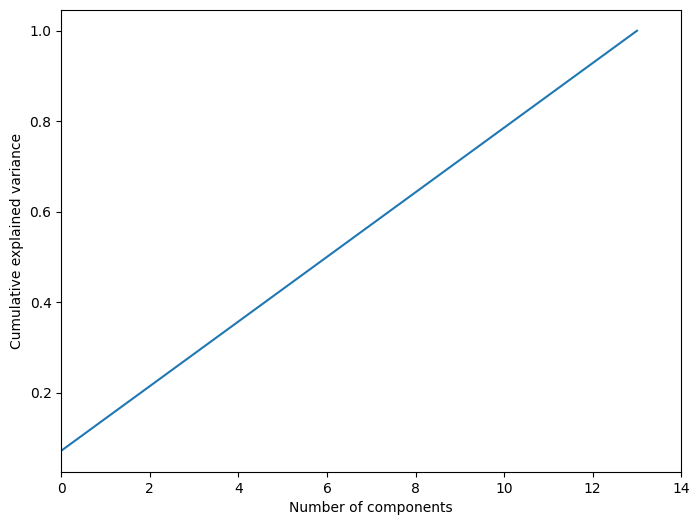

In [83]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### 結論

このカーネルでは、最も一般的な次元削減手法である 主成分分析（PCA） について説明しました。

また、PCAをロジスティック回帰と組み合わせて、adultデータセット上で実装する方法を示しました。

最初の12個の特徴量を使ったときに最大の精度（0.8227）を得られました。

予想どおり、分散の90％を保持するために必要な次元数は12であると判明しました。

最後に、主成分数と分散説明率の関係をプロットし、最初の12成分で約90％の分散が説明されていることを確認しました。